Get the forcing from WebTide (http://www.bio.gc.ca/science/research-recherche/ocean/webtide/index-eng.php) for the Juan de Fuca boundary of the model and created the web forcing files for the model, including all tidal corrections

In [24]:
#preamble
%matplotlib inline
from matplotlib import pylab
import netCDF4 as NC
import csv 
import numpy
from itertools import islice
from math import cos, sin, tan, radians
import sys
import webtide_tools

In [ ]:
# These are the corrections to be used.
tidesetname = 'TS2'
#list of constituents in Webtide predictions
constlist = ['O1', 'Q1', 'K1', 'N2', 'M2', 'S2']
# these are the Fine Tuning Correction Factors.
# A means All, A2 : all semi-diurnals, A1: all diurnals
CFactors = {'A2 Flux':1.2240, 'A2 Phase': -13.18, 'A2 Amp': 0.898,
            'S2 Phase': 0.9, 'S2 Amp': 1.037,
            'N2 Phase': 0.5, 'N2 Amp': 0.974,
            'K2 Phase': 0., 'K2 Amp': 0.,
            'A1 Phase': -18.0, 'A1 Amp': 1.076,
            'O1 Phase': +13.6, 'O1 Amp': 0.999,
            'Q1 Phase': +12.9, 'Q1 Amp': 0.988}
CFactors['K2 Phase'] = CFactors['S2 Phase'] -5.7
CFactors['K2 Amp'] = CFactors['S2 Amp'] * 0.235
CFactors['P1 Phase'] = - 3.5
CFactors['P1 Amp'] = 0.31

Get the co-ordinates of the boundary and put them in a text file for WebTide. 

Note that surface elevation, u and v are offset from each other on a Arakawa C grid. So the lat/lon of each grid will be different for each of them. We therefore need a different list of co-ordinates to give WebTide for T, U and V.

Use new bathymetry with smoothed JdF mouth.

K1 phase decreased by 5 degrees in U,V,eta.
K1 amplitude increased by factor of 1.15 in U,V,eta
M2 phase decreased by 5 degrees in U,V,eta


In [25]:
#load in the bathymetry netcdf data
#fB = NC.Dataset('../../../nemo-forcing/grid/bathy_meter_SalishSea2.nc','r')
fB = NC.Dataset('../../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')

#get the depth data from the netcdf
depth = fB.variables['Bathymetry'][:]
# masking just causes problems, set depth to 0 on land
depth[depth.mask] = 0
a, b = depth.shape
print(a,b)

(898, 398)


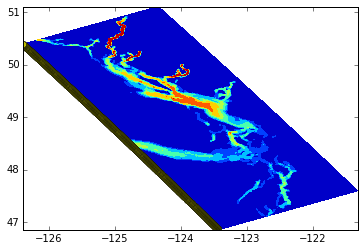

In [26]:
#load in the co-ordinates file
#fC = NC.Dataset('../../../nemo-forcing/grid/coordinates_seagrid_SalishSea.nc','r')
fC = NC.Dataset('../../../NEMO-forcing/grid/coordinates_seagrid_SalishSea.nc','r')

#glam = longitude, gphi = latitude
lonT = fC.variables['glamt'][0,:,0]
latT = fC.variables['gphit'][0,:,0]
lonU = fC.variables['glamu'][0,:,0]
latU = fC.variables['gphiu'][0,:,0]
lonV = fC.variables['glamv'][0,:,0]
latV = fC.variables['gphiv'][0,:,0]

#check it's the right boundary :)
pylab.contourf(fC.variables['glamt'][0,:,:],fC.variables['gphit'][0,:,:],depth)
pylab.plot(lonT,latT,'oy')

number of T cells along boundary = 77
number of U cells along boundary = 77
number of V cells along boundary = 78


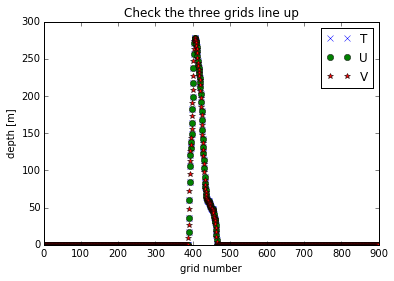

In [27]:
#i and j indices of the western boundary
i = a-1
j = 0

#find the boundary from the depth data
depthT = depth[:,j]
depthU = 0.5*(depth[:,j]+depth[:,j+1])
depthV = numpy.zeros(len(depthT))
depthV[0:i-1] = 0.5*(depth[0:i-1,j]+depth[1:i,j])
depthV[i] = depth[i,j]

#plot all the depth data
#if the three depth variables line up then I've done it right!
pylab.plot(depthT,'x',depthU,'o',depthV,'*')
pylab.xlabel('grid number')
pylab.ylabel('depth [m]')
pylab.legend(('T','U','V'))
pylab.title('Check the three grids line up')

#find where lats and lons the depths are not 0 - this is the boundary
boundlatT = latT[depthT!=0]
boundlonT = lonT[depthT!=0]
boundlatU = latU[depthU!=0]
boundlonU = lonU[depthU!=0]
boundlatV = latV[depthV!=0]
boundlonV = lonV[depthV!=0]

print('number of T cells along boundary = '+str(len(boundlatT)))
print('number of U cells along boundary = '+str(len(boundlatU)))
print('number of V cells along boundary = '+str(len(boundlatV)))

In [28]:
print('T')
I = numpy.where(depthT!=0)
print(I[0][-1]+6)
print(I[0][0]-5)

print(len(depth[I]))
print('u')
print(numpy.where(depthU!=0))
print('v')
print(numpy.where(depthV!=0))

T
471
384
77
u
(array([389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
       402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427,
       428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
       441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453,
       454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465]),)
v
(array([388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465]),)


In [29]:
#Write the lats and lons of each grid to a text file

#T grid
#create a .csv file of lat/lons for tidal elevation predictions, to import into Webtide
with open('jdf_boundary_coords_T.txt', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    for t in numpy.arange(0,len(boundlatT)):
            writer.writerow([boundlonT[t],boundlatT[t]])         
            
#U grid
#create a .csv file of lat/lons for tidal elevation predictions, to import into Webtide
with open('jdf_boundary_coords_U.txt', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    for t in numpy.arange(0,len(boundlatU)):
            writer.writerow([boundlonU[t],boundlatU[t]])         

#V grid
#create a .csv file of lat/lons for tidal elevation predictions, to import into Webtide
with open('jdf_boundary_coords_V.txt', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    for t in numpy.arange(0,len(boundlatV)):
            writer.writerow([boundlonV[t],boundlatV[t]])         

Now I start the WebTide application, select 'Import Tide Markers' then select 'Get Constituents'. An html page opens with the constituents for each of the points. I select all the data and copy into a .csv file. I do this separately for T, U and V grids. For the T grid, I get constituents for elevation. For the U grid, I get constituents for currents but I only use the u component. For the V grid, I get constituents for currents but I only use the v component.

NOTE: I did this once for the subdomain grid, but the lat/lon of the boundary points didn't change so I didn't change it for the bigger domain.


## Read in Webtide data, change from amplitude/phase to Z1/Z2 (required by NEMO) and create NetCDF files

In [30]:
reload(webtide_tools)

<module 'webtide_tools' from 'webtide_tools.pyc'>

87
87
87
78
87
87
87
78
87
87
87
78
87
87
87
78
87
87
87
78
87
87
87
78
87
87
87
78
87
87
87
78


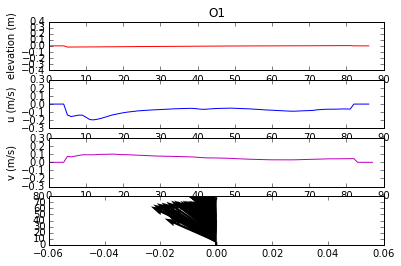

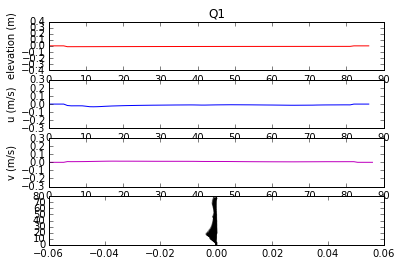

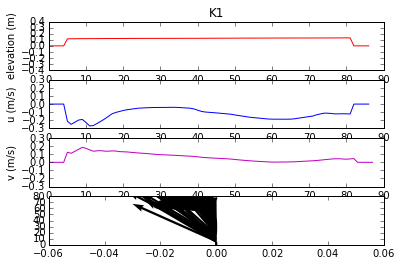

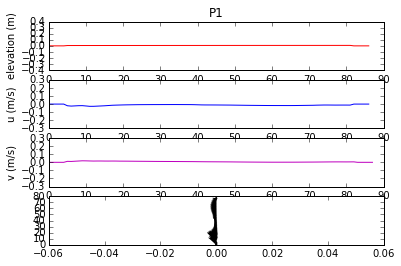

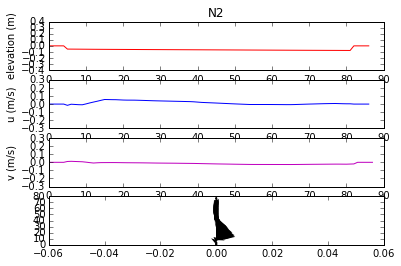

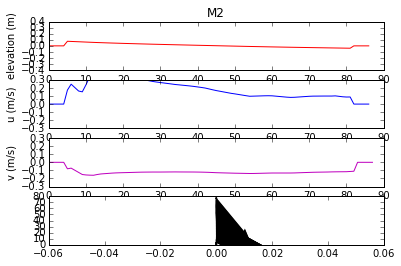

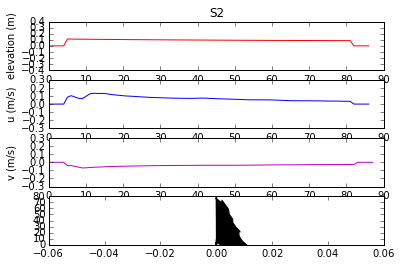

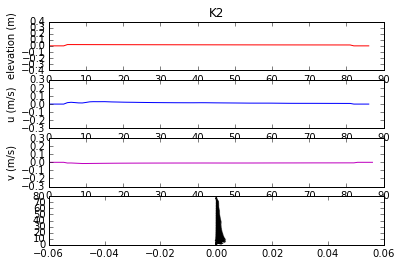

In [31]:
# Use the flux/amplitude/phase corrections and calculate and write the files.


for i in numpy.arange(0,len(constlist)):
    
    #get the predictsion results for elevation, y and v and convert to required format
    #the last number, puts a number after SalishSea.  Here a "2" says the bathymetry with
    #smoothed JdF mouth
    elZ1, elZ2 = webtide_tools.create_tide_netcdf('T', constlist[i], depthT, '2', tidesetname, CFactors)
    uZ1, uZ2 = webtide_tools.create_tide_netcdf('U', constlist[i], depthU, '2', tidesetname, CFactors)
    vZ1, vZ2 = webtide_tools.create_tide_netcdf('V', constlist[i], depthV, '2', tidesetname, CFactors)
    
    #plot the results for each constituent to check it makes sense
    pylab.figure()
    #define some arbitrary time to check results
    theta1 = numpy.pi/4

    #plot the elevation results
    pylab.subplot(4,1,1)
    Ael = numpy.sqrt(elZ1**2+elZ2**2)
    phiel = -numpy.arctan2(elZ2,elZ1)
    elN = Ael*numpy.cos(theta1-phiel)
    pylab.title(constlist[i])
    pylab.plot(elN,'r')
    pylab.ylabel('elevation (m)')
    pylab.ylim((-0.4,0.4))
    
    #calculate the actual components u and v
    Au = numpy.sqrt(uZ1**2+uZ2**2)
    Av = numpy.sqrt(vZ1**2+vZ2**2)
    phiu = -numpy.arctan2(uZ2,uZ1)
    phiv = -numpy.arctan2(vZ2,vZ1)
    uN = Au*numpy.cos(theta1-phiu)
    vN = Av*numpy.cos(theta1-phiv)
    
    #plot the u and v velocities separately
    pylab.subplot(4,1,2)
    pylab.plot(uN,'b')
    pylab.ylabel('u (m/s)')
    pylab.ylim((-0.3,0.3))

    pylab.subplot(4,1,3)
    pylab.plot(vN,'m')
    pylab.ylabel('v (m/s)')
    pylab.ylim((-0.3,0.3))
    
    #make a little quiver plot to check this makes sense
    pylab.subplot(4,1,4)
    pylab.quiver([0]*78,numpy.linspace(0,77,78),uN[0:76],vN[0:76],scale=1)

#    print phiel*180/numpy.pi